# Runge Function Approximation Assignment (Derivative Version)

Click [here](#derivative) to head to the **HW3** part.

Author: Alvin B. Lin\
Date: 10/09/2025\
HW: 2\
*Special Thanks to My Relyable Partner Google Gemini.* 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Comparing the Optimisers

In [2]:
# --- 1. Generate the data ---
def runge_function(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# Generate a dense set of points for plotting
x_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_plot = runge_function(x_plot)

# Significantly increase the number of training and validation points
num_train_points = 500
num_val_points = 20
x_train_np = np.linspace(-1, 1, num_train_points).reshape(-1, 1)
y_train_np = runge_function(x_train_np)

x_val_np = np.linspace(-1, 1, num_val_points).reshape(-1, 1)
y_val_np = runge_function(x_val_np)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
x_val = torch.tensor(x_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)
x_plot_tensor = torch.tensor(x_plot, dtype=torch.float32)

The training set size is set as 100, and the validation/text set size is set for 20.

In [3]:
# --- 2. Define the Neural Network ---
class RungeApproximator(nn.Module):
    def __init__(self, hidden_size=50):
        super(RungeApproximator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.net(x)

Here we create a 2-layer, with each layer 50 neurons, neural network, for which the activation function is selected as $\tanh x$.

In [4]:
# --- 3. Custom Loss Function for Sup-norm Approximation ---
class LPNormLoss(nn.Module):
    def __init__(self, p=20):
        super(LPNormLoss, self).__init__()
        self.p = p

    def forward(self, y_pred, y_true):
        error = torch.abs(y_pred - y_true)
        epsilon = 1e-10
        log_term = self.p * torch.log(error + epsilon)
        log_sum = torch.logsumexp(log_term, dim=0)
        loss = log_sum / self.p
        return loss

The programme has 2 different methods of approximation for which differ by the selection of optimiser. One with standard **MSE** method; while the other with **sup-norm** (also **infinity-norm**). We aim to compare the approximation results between both methods.

The loss function for the **sup-norm** is given by:
$$ L_{sup} = \frac{1}{p} \log\left(\sum_{i = 1}^{N} \exp(p\log(\mid y_i - \hat{y}_i\mid))\right) $$
 where $N$ is the size of teh training set, $p$ for sufficient large integer, here picked as 20.

We first start with the **MSE** method, to be fair, we set the *epoch* to 5000. And the loss after per 500 recurrences will be displayed in the output.

In [5]:
# --- 4. Training with MSE Loss ---
print("--- Training with MSE Loss ---")

model_mse = RungeApproximator()
optimizer_mse = optim.Adam(model_mse.parameters(), lr=0.01)
criterion_mse = nn.MSELoss()

epochs = 5000
train_loss_history_mse = []
val_loss_history_mse = []

for epoch in range(epochs):
    model_mse.train()
    optimizer_mse.zero_grad()
    
    y_pred = model_mse(x_train)
    loss = criterion_mse(y_pred, y_train)
    
    loss.backward()
    optimizer_mse.step()
    
    model_mse.eval()
    with torch.no_grad():
        y_val_pred = model_mse(x_val)
        val_loss = criterion_mse(y_val_pred, y_val)
        
    train_loss_history_mse.append(loss.item())
    val_loss_history_mse.append(val_loss.item())

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')

--- Training with MSE Loss ---
Epoch [500/5000], Train Loss: 0.000005, Val Loss: 0.000007
Epoch [1000/5000], Train Loss: 0.000001, Val Loss: 0.000001
Epoch [1500/5000], Train Loss: 0.000000, Val Loss: 0.000001
Epoch [2000/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [2500/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [3000/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [3500/5000], Train Loss: 0.000000, Val Loss: 0.000001
Epoch [4000/5000], Train Loss: 0.000525, Val Loss: 0.000513
Epoch [4500/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [5000/5000], Train Loss: 0.000000, Val Loss: 0.000000


Here we visualise the result getting from the **MSE** method.

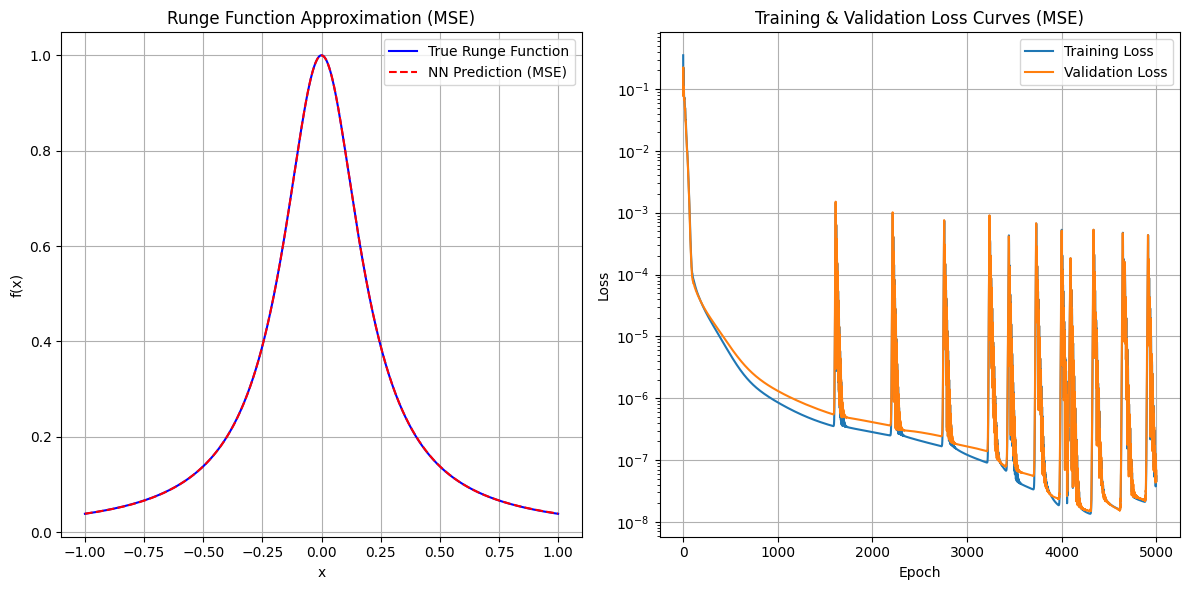

Final MSE: 0.000000
Final Max Absolute Error (Sup-norm): 0.000489


In [6]:
# --- 5. Evaluation and Plotting for MSE ---
model_mse.eval()
with torch.no_grad():
    y_pred_mse = model_mse(x_plot_tensor).numpy()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_plot, y_plot, label='True Runge Function', color='blue')
plt.plot(x_plot, y_pred_mse, label='NN Prediction (MSE)', color='red', linestyle='--')
plt.title('Runge Function Approximation (MSE)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_history_mse, label='Training Loss')
plt.plot(val_loss_history_mse, label='Validation Loss')
plt.title('Training & Validation Loss Curves (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

mse_val_error_mse = np.mean((y_pred_mse - y_plot)**2)
max_abs_error_val_mse = np.max(np.abs(y_pred_mse - y_plot))
print(f"Final MSE: {mse_val_error_mse:.6f}")
print(f"Final Max Absolute Error (Sup-norm): {max_abs_error_val_mse:.6f}")

In [7]:
# --- 6. Training with Sup-norm Approximation Loss ---
print("\n--- Training with Sup-norm Approximation Loss (Corrected) ---")

model_sup = RungeApproximator()
optimizer_sup = optim.Adam(model_sup.parameters(), lr=0.01)
criterion_sup = LPNormLoss(p=20)

epochs = 5000
train_loss_history_sup = []
val_loss_history_sup = []

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sup, 'min', patience=200, factor=0.5)

for epoch in range(epochs):
    model_sup.train()
    optimizer_sup.zero_grad()
    
    y_pred = model_sup(x_train)
    loss = criterion_sup(y_pred, y_train)
    
    loss.backward()
    optimizer_sup.step()
    
    model_sup.eval()
    with torch.no_grad():
        y_val_pred = model_sup(x_val)
        val_loss = criterion_sup(y_val_pred, y_val)
    
    scheduler.step(val_loss)
        
    train_loss_history_sup.append(loss.item())
    val_loss_history_sup.append(val_loss.item())

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')


--- Training with Sup-norm Approximation Loss (Corrected) ---
Epoch [500/5000], Train Loss: -2.387365, Val Loss: -2.574383
Epoch [1000/5000], Train Loss: -3.671196, Val Loss: -3.951736
Epoch [1500/5000], Train Loss: -4.486544, Val Loss: -4.521039
Epoch [2000/5000], Train Loss: -5.462722, Val Loss: -6.061852
Epoch [2500/5000], Train Loss: -5.983633, Val Loss: -6.394040
Epoch [3000/5000], Train Loss: -6.842200, Val Loss: -7.062901
Epoch [3500/5000], Train Loss: -6.592715, Val Loss: -6.947968
Epoch [4000/5000], Train Loss: -7.230442, Val Loss: -7.403600
Epoch [4500/5000], Train Loss: -7.329293, Val Loss: -7.436362
Epoch [5000/5000], Train Loss: -7.342224, Val Loss: -7.450474


The following is for the **sup-norm** method. Again, the *epoch* and other parametres are set as the ones in **MSE** method.

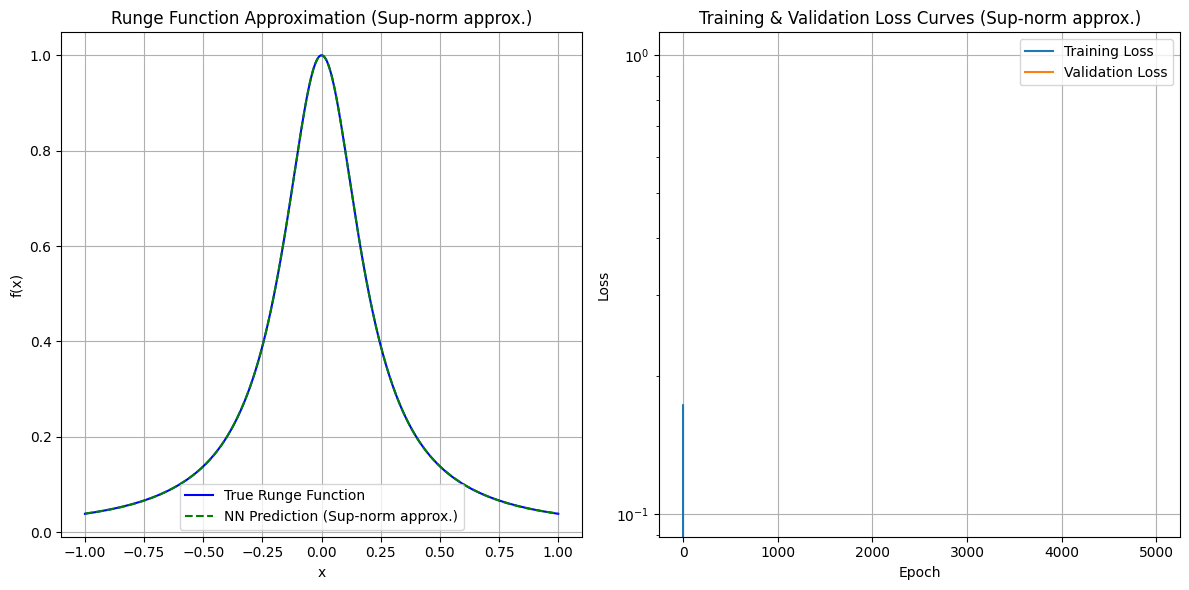

Final MSE: 0.000000
Final Max Absolute Error (Sup-norm): 0.000564


In [8]:
# --- 7. Evaluation and Plotting for Sup-norm ---
model_sup.eval()
with torch.no_grad():
    y_pred_sup = model_sup(x_plot_tensor).numpy()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_plot, y_plot, label='True Runge Function', color='blue')
plt.plot(x_plot, y_pred_sup, label='NN Prediction (Sup-norm approx.)', color='green', linestyle='--')
plt.title('Runge Function Approximation (Sup-norm approx.)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_history_sup, label='Training Loss')
plt.plot(val_loss_history_sup, label='Validation Loss')
plt.title('Training & Validation Loss Curves (Sup-norm approx.)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

mse_val_error_sup = np.mean((y_pred_sup - y_plot)**2)
max_abs_error_val_sup = np.max(np.abs(y_pred_sup - y_plot))
print(f"Final MSE: {mse_val_error_sup:.6f}")
print(f"Final Max Absolute Error (Sup-norm): {max_abs_error_val_sup:.6f}")

One may ask why the losses between 2 methods can vary so much. The reason is quite simple, different optimisers needs different scales, direct comparison cannnot really distinguish which method is better. Hence we try to re-scale the loss in the **sup-norm** method, and further do the comparison.

In [9]:
# --- 8. Final Comparison of Results ---
print("\n--- Final Results Comparison ---")

print("----------------------------------------------------------------------")
print("         Metric         |    MSE Method   | Sup-Norm Method")
print("----------------------------------------------------------------------")
print(f"Final MSE               |  {mse_val_error_mse:.6f}       |  {mse_val_error_sup:.6f}")
print(f"Final Max Abs Error     |  {max_abs_error_val_mse:.6f}       |  {max_abs_error_val_sup:.6f}")
print("----------------------------------------------------------------------")

# Determine which method is "better" based on max absolute error
# since that is the metric the sup-norm method is designed to optimize.
if max_abs_error_val_sup < max_abs_error_val_mse:
    print("\nConclusion: The Sup-Norm method achieved a lower maximum absolute error, making it the better method for this specific objective.")
elif max_abs_error_val_mse < max_abs_error_val_sup:
    print("\nConclusion: The MSE method achieved a lower maximum absolute error, making it the better method for this specific objective.")
else:
    print("\nConclusion: Both methods achieved a very similar result for the maximum absolute error.")


--- Final Results Comparison ---
----------------------------------------------------------------------
         Metric         |    MSE Method   | Sup-Norm Method
----------------------------------------------------------------------
Final MSE               |  0.000000       |  0.000000
Final Max Abs Error     |  0.000489       |  0.000564
----------------------------------------------------------------------

Conclusion: The MSE method achieved a lower maximum absolute error, making it the better method for this specific objective.


The result shows that under the same amount of time and the same condition, **sup-norm** method is the better of the two.\
One may ask about the running time, in theoretical perspective, they share the same time complexity of $\mathcal{O}(N)$ for the computation of loss function, for $N$ stands for the size of the training data set.\
The tradeoff of the **sup-norm** method, I think is the computational formula complexity, the loss function involves *logrithm* and the *exponential* function,it is not easy yo take the derivative for a good form, so it is not as simple as the **MSE** when calculating the loss by hands.

## Part 2: Approximate with Cosine Function

Setting for the new neural network which use $\cos x$ as **activation function**.

In [10]:
# --- Training with Cosine Activation Function ---
print("\n--- Training with Cosine Activation Function ---")

# Define the Neural Network with Cosine Activation
class RungeApproximatorCosine(nn.Module):
    def __init__(self, hidden_size=50):
        super(RungeApproximatorCosine, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            # Use torch.cos as the activation function
            nn.Identity(), # This is a placeholder for the activation function
            nn.Linear(hidden_size, hidden_size),
            nn.Identity(), # This is a placeholder for the activation function
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        x = torch.cos(self.net[0](x))
        x = torch.cos(self.net[2](x))
        return self.net[4](x)
    
model_cos = RungeApproximatorCosine()
optimizer_cos = optim.Adam(model_cos.parameters(), lr=0.01)
criterion_cos = nn.MSELoss()


--- Training with Cosine Activation Function ---


Setting *epoch* to 5000, the other parametres remain the same.

In [11]:
epochs = 5000
train_loss_history_cos = []
val_loss_history_cos = []

for epoch in range(epochs):
    model_cos.train()
    optimizer_cos.zero_grad()
    
    y_pred = model_cos(x_train)
    loss = criterion_cos(y_pred, y_train)
    
    loss.backward()
    optimizer_cos.step()
    
    model_cos.eval()
    with torch.no_grad():
        y_val_pred = model_cos(x_val)
        val_loss = criterion_cos(y_val_pred, y_val)
        
    train_loss_history_cos.append(loss.item())
    val_loss_history_cos.append(val_loss.item())

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')


Epoch [500/5000], Train Loss: 0.000209, Val Loss: 0.000202
Epoch [1000/5000], Train Loss: 0.000040, Val Loss: 0.000035
Epoch [1500/5000], Train Loss: 0.000034, Val Loss: 0.000023
Epoch [2000/5000], Train Loss: 0.000082, Val Loss: 0.000059
Epoch [2500/5000], Train Loss: 0.000008, Val Loss: 0.000007
Epoch [3000/5000], Train Loss: 0.000003, Val Loss: 0.000001
Epoch [3500/5000], Train Loss: 0.000002, Val Loss: 0.000001
Epoch [4000/5000], Train Loss: 0.000001, Val Loss: 0.000000
Epoch [4500/5000], Train Loss: 0.000001, Val Loss: 0.000001
Epoch [5000/5000], Train Loss: 0.000010, Val Loss: 0.000006


Visualise the result of approximation.

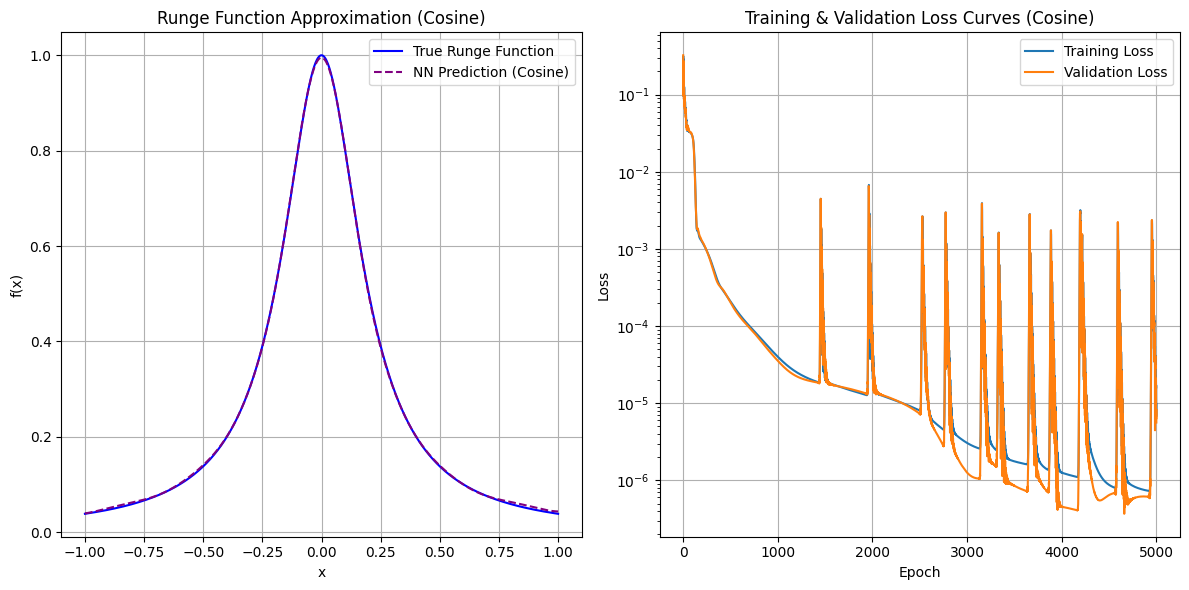

Final MSE: 0.000006
Final Max Absolute Error (Sup-norm): 0.005360


In [12]:
# --- Evaluation and Plotting for Cosine Network ---
model_cos.eval()
with torch.no_grad():
    y_pred_cos = model_cos(x_plot_tensor).numpy()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_plot, y_plot, label='True Runge Function', color='blue')
plt.plot(x_plot, y_pred_cos, label='NN Prediction (Cosine)', color='purple', linestyle='--')
plt.title('Runge Function Approximation (Cosine)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_history_cos, label='Training Loss')
plt.plot(val_loss_history_cos, label='Validation Loss')
plt.title('Training & Validation Loss Curves (Cosine)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

mse_val_error_cos = np.mean((y_pred_cos - y_plot)**2)
max_abs_error_val_cos = np.max(np.abs(y_pred_cos - y_plot))
print(f"Final MSE: {mse_val_error_cos:.6f}")
print(f"Final Max Absolute Error (Sup-norm): {max_abs_error_val_cos:.6f}")

## Part 3: Epoch Comparison

In this part we compare the *epoch*, testing how many iterations is it good enough for approximation. We first use $\tanh x$ as activation function and **MSE** for the loss function.

--- Training with Tanh Activation Function (MSE Loss) ---
Epoch [500/5000], Train Loss: 0.000010
Epoch [1000/5000], Train Loss: 0.000003
Epoch [1500/5000], Train Loss: 0.000001
Epoch [2000/5000], Train Loss: 0.000001
Epoch [2500/5000], Train Loss: 0.000000
Epoch [3000/5000], Train Loss: 0.000000
Epoch [3500/5000], Train Loss: 0.000000
Epoch [4000/5000], Train Loss: 0.000000
Epoch [4500/5000], Train Loss: 0.000000
Epoch [5000/5000], Train Loss: 0.000000


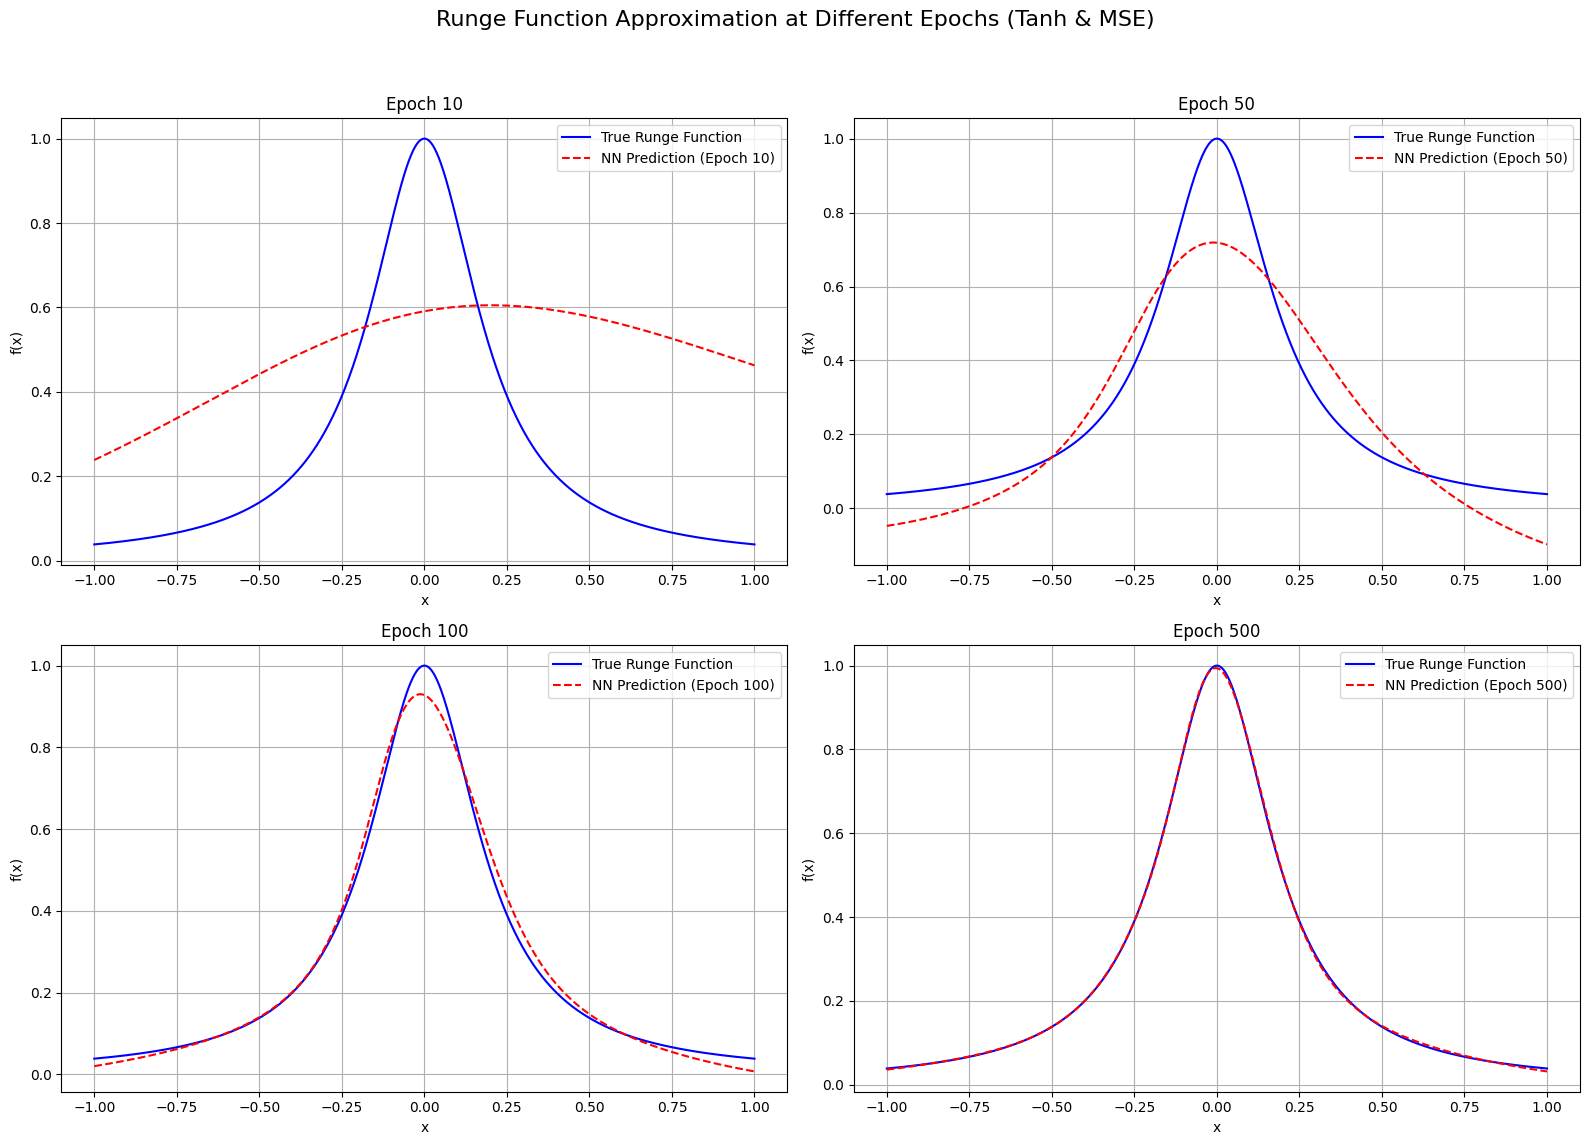

Final MSE: 0.000000
Final Max Absolute Error: 0.000686


In [13]:
# --- Tanh Model & MSE Loss Training ---
print("--- Training with Tanh Activation Function (MSE Loss) ---")

# Define the Neural Network
class RungeApproximator(nn.Module):
    def __init__(self, hidden_size=50):
        super(RungeApproximator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.net(x)

# Create model, optimizer, and loss criterion
model_tanh = RungeApproximator()
optimizer_tanh = optim.Adam(model_tanh.parameters(), lr=0.01)
criterion_tanh = nn.MSELoss()

epochs = 5000
epochs_to_plot = [10, 50, 100, 500]
models_to_plot = {}  # Dictionary to store models at specific epochs

for epoch in range(1, epochs + 1):
    model_tanh.train()
    optimizer_tanh.zero_grad()
    
    y_pred = model_tanh(x_train)
    loss = criterion_tanh(y_pred, y_train)
    
    loss.backward()
    optimizer_tanh.step()
    
    if epoch in epochs_to_plot:
        # Save a deep copy of the model at this epoch
        models_to_plot[epoch] = copy.deepcopy(model_tanh)
        
    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.6f}')

# --- Plotting the Results ---
# Create a 2x2 grid of plots
plt.figure(figsize=(16, 12))
plt.suptitle('Runge Function Approximation at Different Epochs (Tanh & MSE)', fontsize=16)

# Generate a dense set of points for plotting
x_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_plot = 1.0 / (1.0 + 25.0 * x_plot**2)
x_plot_tensor = torch.tensor(x_plot, dtype=torch.float32)

for i, epoch in enumerate(epochs_to_plot):
    ax = plt.subplot(2, 2, i + 1)
    
    # Get the model at the specified epoch
    model_at_epoch = models_to_plot[epoch]
    model_at_epoch.eval()
    with torch.no_grad():
        y_pred_at_epoch = model_at_epoch(x_plot_tensor).numpy()

    # Plot the results
    ax.plot(x_plot, y_plot, label='True Runge Function', color='blue')
    ax.plot(x_plot, y_pred_at_epoch, label=f'NN Prediction (Epoch {epoch})', color='red', linestyle='--')
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final evaluation after full training
model_tanh.eval()
with torch.no_grad():
    y_pred_tanh = model_tanh(x_plot_tensor).numpy()

mse_val_error_tanh = np.mean((y_pred_tanh - y_plot)**2)
max_abs_error_val_tanh = np.max(np.abs(y_pred_tanh - y_plot))
print(f"Final MSE: {mse_val_error_tanh:.6f}")
print(f"Final Max Absolute Error: {max_abs_error_val_tanh:.6f}")

Now for the **sup-norm** version loss function.


--- Training with Sup-norm Approximation Loss (Corrected) ---


c:\Users\benny\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  current = float(metrics)


Epoch [500/5000], Train Loss: -3.444629
Epoch [1000/5000], Train Loss: -3.992204
Epoch [1500/5000], Train Loss: -2.794106
Epoch [2000/5000], Train Loss: -4.729499
Epoch [2500/5000], Train Loss: -6.249923
Epoch [3000/5000], Train Loss: -6.433843
Epoch [3500/5000], Train Loss: -6.674612
Epoch [4000/5000], Train Loss: -6.849730
Epoch [4500/5000], Train Loss: -7.255769
Epoch [5000/5000], Train Loss: -6.889417


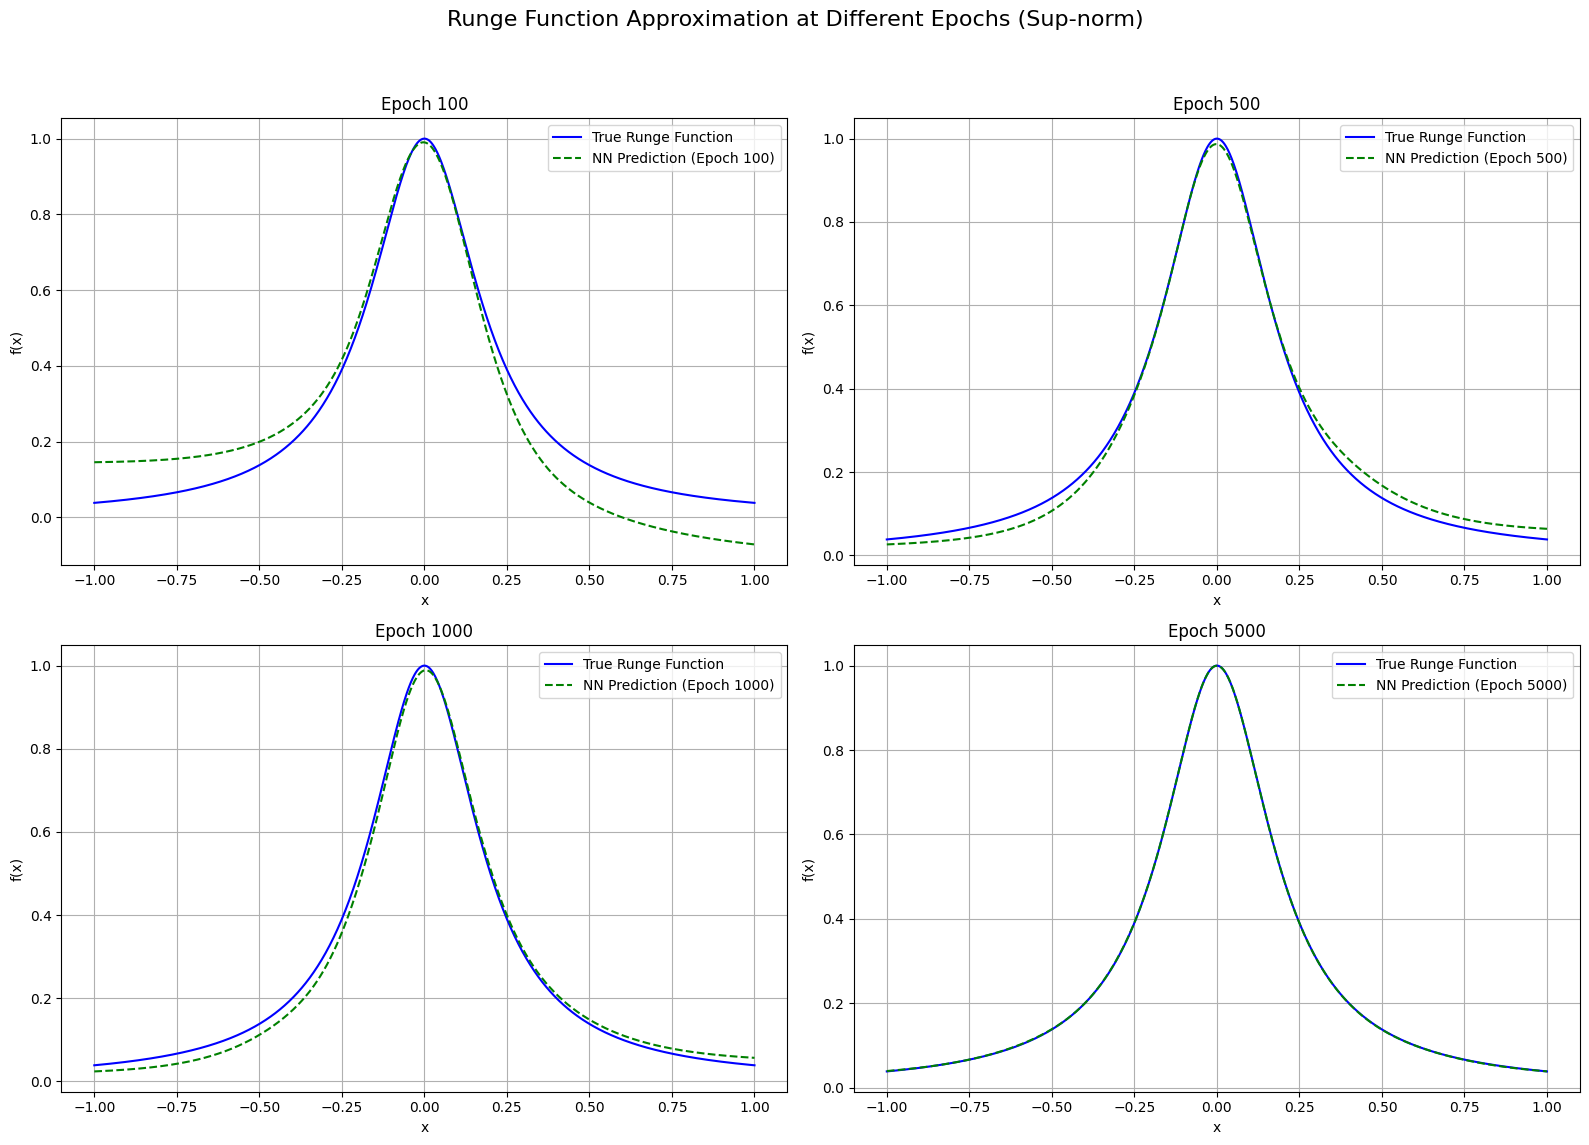

Final MSE: 0.000000
Final Max Absolute Error: 0.000911


In [14]:
# --- Sup-norm Loss Training ---
print("\n--- Training with Sup-norm Approximation Loss (Corrected) ---")

# Create model, optimizer, and loss criterion
model_sup = RungeApproximator()
optimizer_sup = optim.Adam(model_sup.parameters(), lr=0.01)
criterion_sup = LPNormLoss(p=20)

# Add a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sup, 'min', patience=200, factor=0.5)

epochs = 5000
epochs_to_plot = [100, 500, 1000, 5000]
models_to_plot = {}  # Dictionary to store models at specific epochs

# Assumes x_train and y_train are already defined
# For example:
x_train_np = np.linspace(-1, 1, 500).reshape(-1, 1)
y_train_np = 1.0 / (1.0 + 25.0 * x_train_np**2)
x_train = torch.tensor(x_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)

for epoch in range(1, epochs + 1):
    model_sup.train()
    optimizer_sup.zero_grad()
    
    y_pred = model_sup(x_train)
    loss = criterion_sup(y_pred, y_train)
    
    loss.backward()
    optimizer_sup.step()
    
    # Take a scheduler step based on the training loss
    scheduler.step(loss)
    
    if epoch in epochs_to_plot:
        # Save a deep copy of the model at this epoch
        models_to_plot[epoch] = copy.deepcopy(model_sup)
        
    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.6f}')

# --- Plotting the Results ---
# Create a 2x2 grid of plots
plt.figure(figsize=(16, 12))
plt.suptitle('Runge Function Approximation at Different Epochs (Sup-norm)', fontsize=16)

# Generate a dense set of points for plotting
x_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_plot = 1.0 / (1.0 + 25.0 * x_plot**2)
x_plot_tensor = torch.tensor(x_plot, dtype=torch.float32)

for i, epoch in enumerate(epochs_to_plot):
    ax = plt.subplot(2, 2, i + 1)
    
    # Get the model at the specified epoch
    model_at_epoch = models_to_plot[epoch]
    model_at_epoch.eval()
    with torch.no_grad():
        y_pred_at_epoch = model_at_epoch(x_plot_tensor).numpy()

    # Plot the results
    ax.plot(x_plot, y_plot, label='True Runge Function', color='blue')
    ax.plot(x_plot, y_pred_at_epoch, label=f'NN Prediction (Epoch {epoch})', color='green', linestyle='--')
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final evaluation after full training
model_sup.eval()
with torch.no_grad():
    y_pred_sup = model_sup(x_plot_tensor).numpy()

mse_val_error_sup = np.mean((y_pred_sup - y_plot)**2)
max_abs_error_val_sup = np.max(np.abs(y_pred_sup - y_plot))
print(f"Final MSE: {mse_val_error_sup:.6f}")
print(f"Final Max Absolute Error: {max_abs_error_val_sup:.6f}")

Lastly, we do expirement on $\cos x$ activated, **MSE** as loss function one.

--- Training with Cosine Activation Function (MSE Loss) ---
Epoch [500/5000], Train Loss: 0.000400
Epoch [1000/5000], Train Loss: 0.000078
Epoch [1500/5000], Train Loss: 0.000036
Epoch [2000/5000], Train Loss: 0.000014
Epoch [2500/5000], Train Loss: 0.000009
Epoch [3000/5000], Train Loss: 0.000006
Epoch [3500/5000], Train Loss: 0.000004
Epoch [4000/5000], Train Loss: 0.000002
Epoch [4500/5000], Train Loss: 0.000002
Epoch [5000/5000], Train Loss: 0.000001


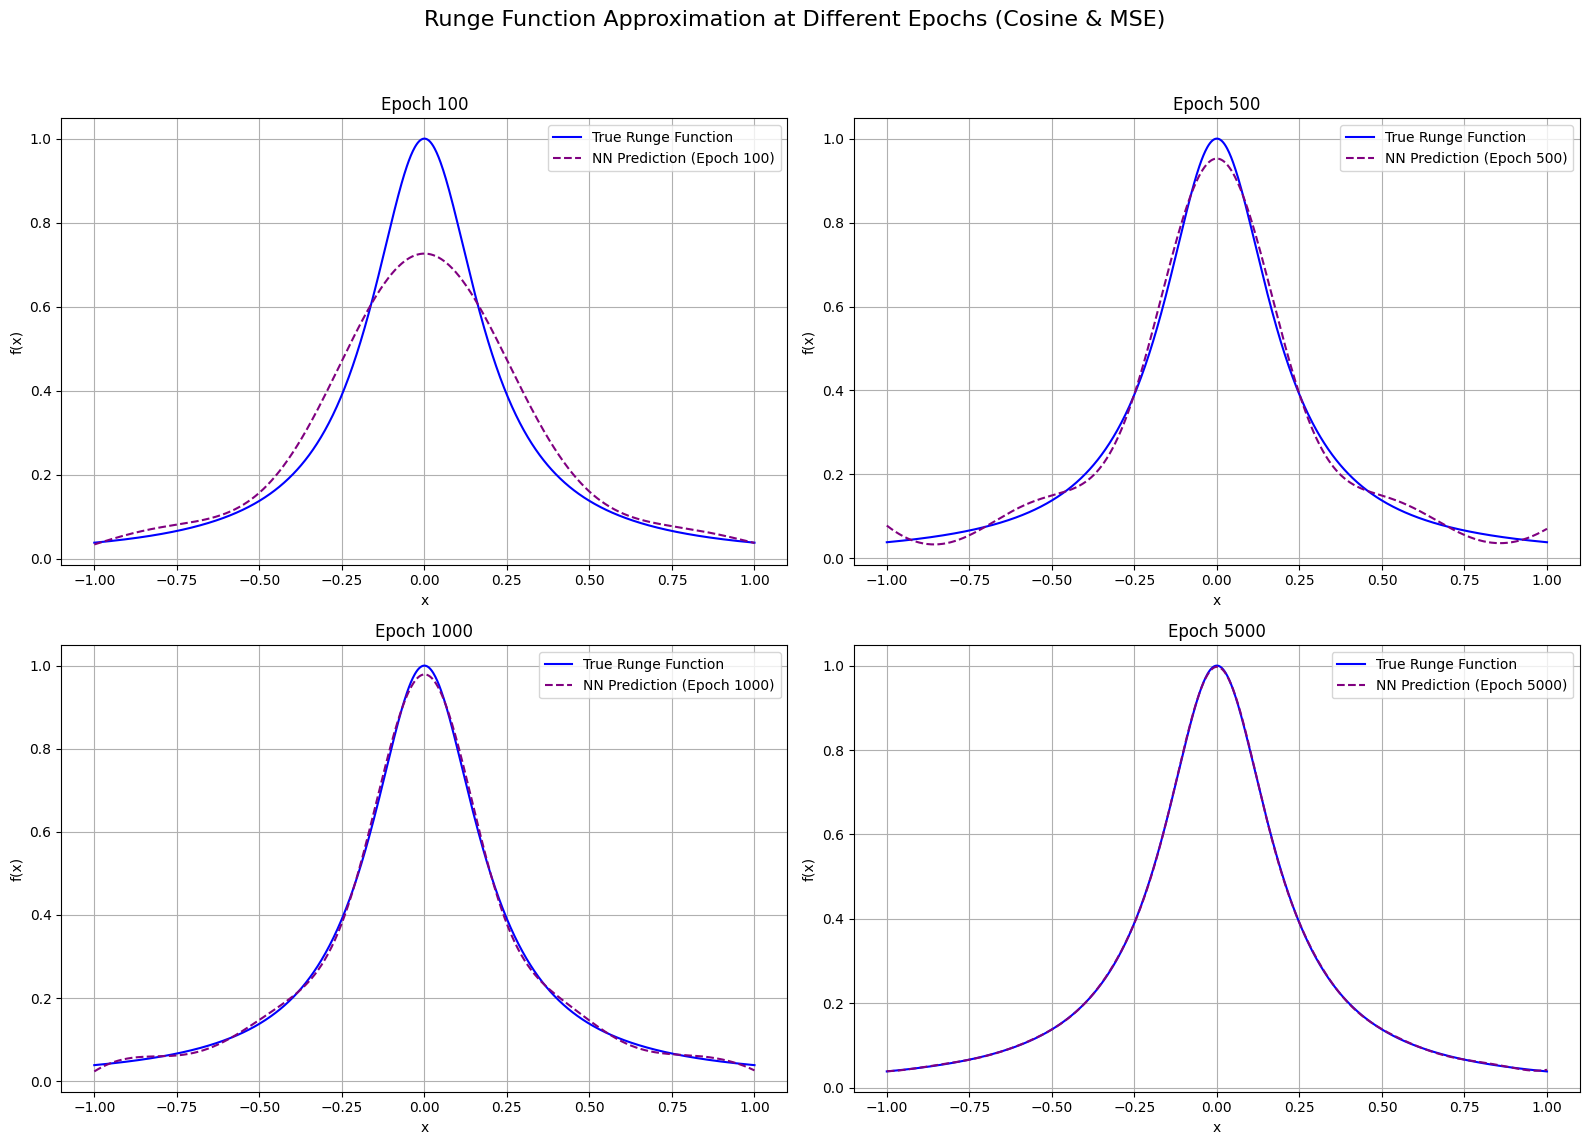

Final MSE: 0.000001
Final Max Absolute Error: 0.003941


In [15]:
# --- Cosine Model & MSE Loss Training ---
print("--- Training with Cosine Activation Function (MSE Loss) ---")

# Define the Neural Network with Cosine Activation
class RungeApproximatorCosine(nn.Module):
    def __init__(self, hidden_size=50):
        super(RungeApproximatorCosine, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            # nn.Identity(), # This is a placeholder for the activation function
            nn.Linear(hidden_size, hidden_size),
            # nn.Identity(), # This is a placeholder for the activation function
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        # Use torch.cos as the activation function
        x = torch.cos(self.net[0](x))
        x = torch.cos(self.net[1](x))
        return self.net[2](x)

# Create model, optimizer, and loss criterion
model_cos = RungeApproximatorCosine()
optimizer_cos = optim.Adam(model_cos.parameters(), lr=0.01)
criterion_cos = nn.MSELoss()

epochs = 5000
epochs_to_plot = [100, 500, 1000, 5000]
models_to_plot = {} # Dictionary to store models at specific epochs

for epoch in range(1, epochs + 1):
    model_cos.train()
    optimizer_cos.zero_grad()
    
    y_pred = model_cos(x_train)
    loss = criterion_cos(y_pred, y_train)
    
    loss.backward()
    optimizer_cos.step()
    
    if epoch in epochs_to_plot:
        # Save a deep copy of the model at this epoch
        models_to_plot[epoch] = copy.deepcopy(model_cos)
        
    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.6f}')

# --- Plotting the Results ---
# Create a 2x2 grid of plots
plt.figure(figsize=(16, 12))
plt.suptitle('Runge Function Approximation at Different Epochs (Cosine & MSE)', fontsize=16)

# Generate a dense set of points for plotting
x_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_plot = 1.0 / (1.0 + 25.0 * x_plot**2)
x_plot_tensor = torch.tensor(x_plot, dtype=torch.float32)

for i, epoch in enumerate(epochs_to_plot):
    ax = plt.subplot(2, 2, i + 1)
    
    # Get the model at the specified epoch
    model_at_epoch = models_to_plot[epoch]
    model_at_epoch.eval()
    with torch.no_grad():
        y_pred_at_epoch = model_at_epoch(x_plot_tensor).numpy()

    # Plot the results
    ax.plot(x_plot, y_plot, label='True Runge Function', color='blue')
    ax.plot(x_plot, y_pred_at_epoch, label=f'NN Prediction (Epoch {epoch})', color='purple', linestyle='--')
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final evaluation after full training
model_cos.eval()
with torch.no_grad():
    y_pred_cos = model_cos(x_plot_tensor).numpy()

mse_val_error_cos = np.mean((y_pred_cos - y_plot)**2)
max_abs_error_val_cos = np.max(np.abs(y_pred_cos - y_plot))
print(f"Final MSE: {mse_val_error_cos:.6f}")
print(f"Final Max Absolute Error: {max_abs_error_val_cos:.6f}")


For $\tanh$ + **MSE** method, after 500 epoch, the model is performed well enough, while the other 2 methods need around 1000 to 5000 epoch to reach the passing threshold.

---

<a id='derivative'></a>
# HW3 Runge Function Error for Derivatives

Author: Alvin B. Lin\
Date: 17/09/2025\
HW: 3\
*Special Thanks to My Relyable Partner Google Gemini.* 

=== 1. Tanh + MSE ===
Epoch [500/5000], Train Loss: 0.000001, Val Loss: 0.000001
Epoch [1000/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [1500/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [2000/5000], Train Loss: 0.000000, Val Loss: 0.000000
Epoch [2500/5000], Train Loss: 0.000002, Val Loss: 0.000001
Epoch [3000/5000], Train Loss: 0.000002, Val Loss: 0.000002
Epoch [3500/5000], Train Loss: 0.000002, Val Loss: 0.000002
Epoch [4000/5000], Train Loss: 0.000001, Val Loss: 0.000001
Epoch [4500/5000], Train Loss: 0.000016, Val Loss: 0.000004
Epoch [5000/5000], Train Loss: 0.000093, Val Loss: 0.000054

Final MSE: 0.000054
Final Max Absolute Error (Sup-norm): 0.019007



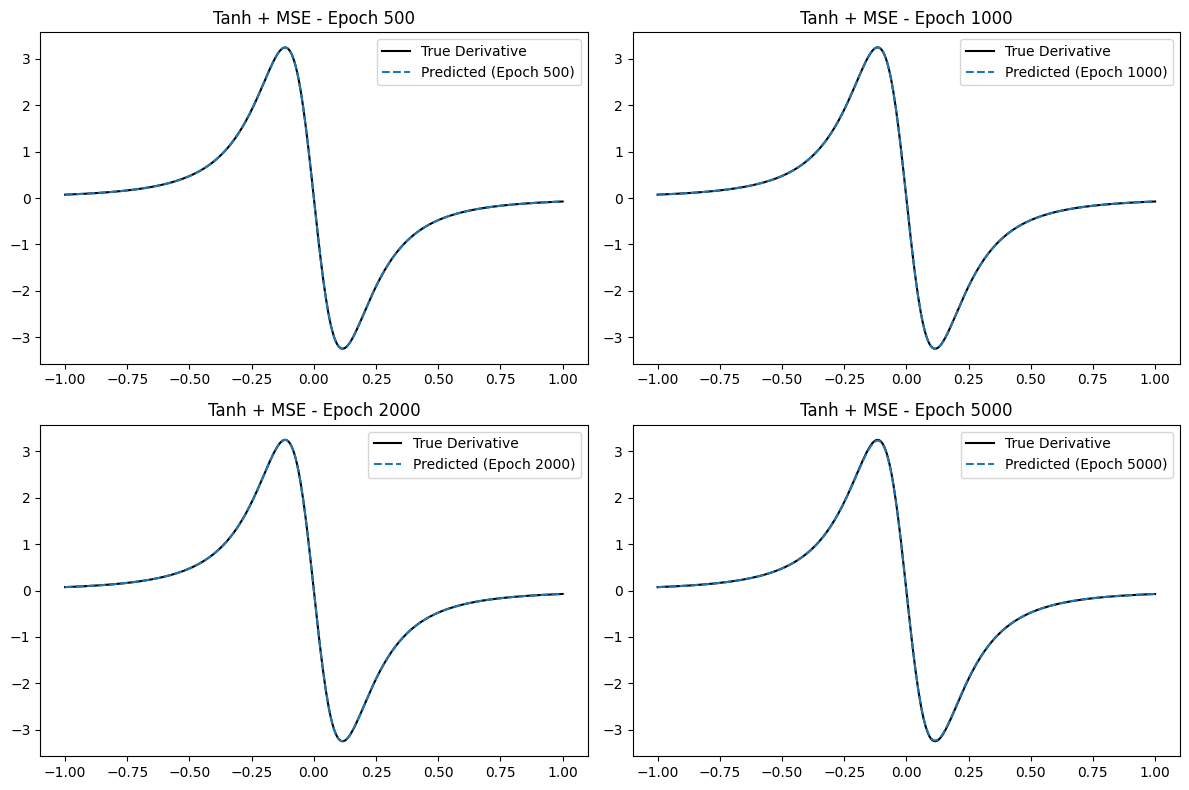

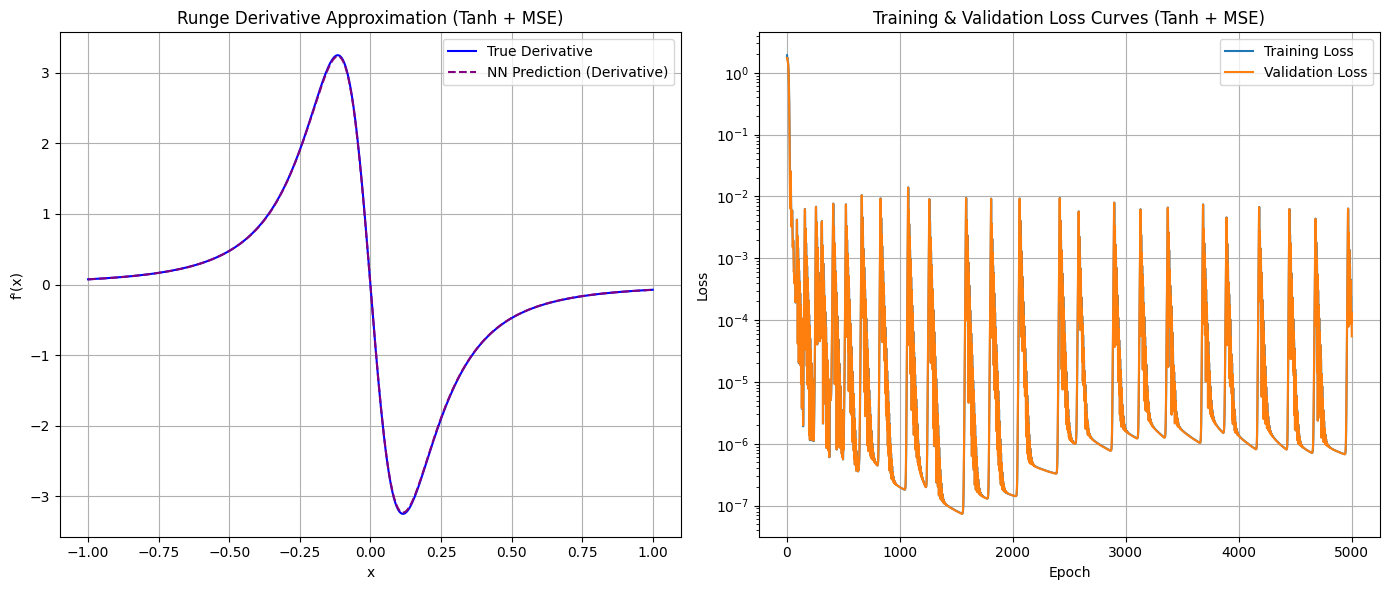

=== 2. Tanh + Sup norm ===
Epoch [500/5000], Train Loss: 0.230913, Val Loss: 0.279092
Epoch [1000/5000], Train Loss: 0.101415, Val Loss: 0.154770
Epoch [1500/5000], Train Loss: 0.089697, Val Loss: 0.163616
Epoch [2000/5000], Train Loss: 0.266273, Val Loss: 0.224421
Epoch [2500/5000], Train Loss: 0.165483, Val Loss: 0.130505
Epoch [3000/5000], Train Loss: 0.140655, Val Loss: 0.108972
Epoch [3500/5000], Train Loss: 0.101032, Val Loss: 0.197650
Epoch [4000/5000], Train Loss: 0.275482, Val Loss: 0.320138
Epoch [4500/5000], Train Loss: 0.138621, Val Loss: 0.139224
Epoch [5000/5000], Train Loss: 0.134372, Val Loss: 0.097872

Final MSE: 0.001418
Final Max Absolute Error (Sup-norm): 0.097872



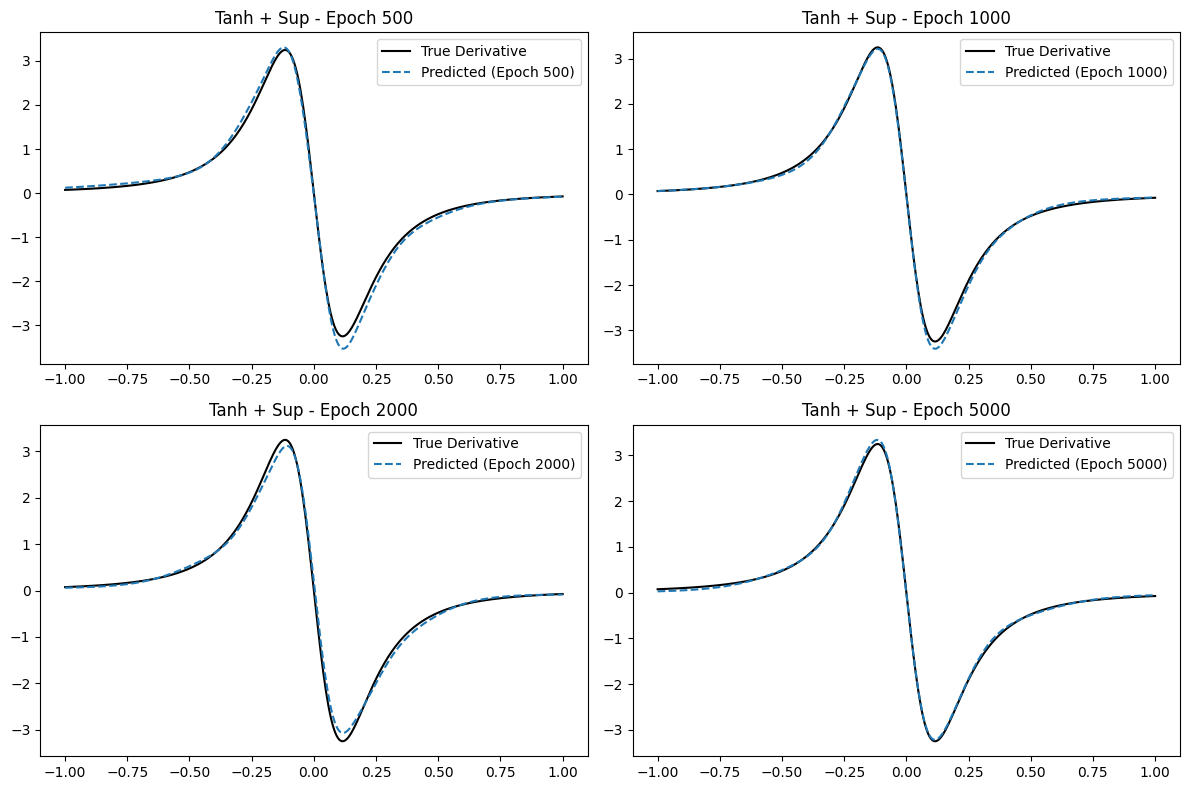

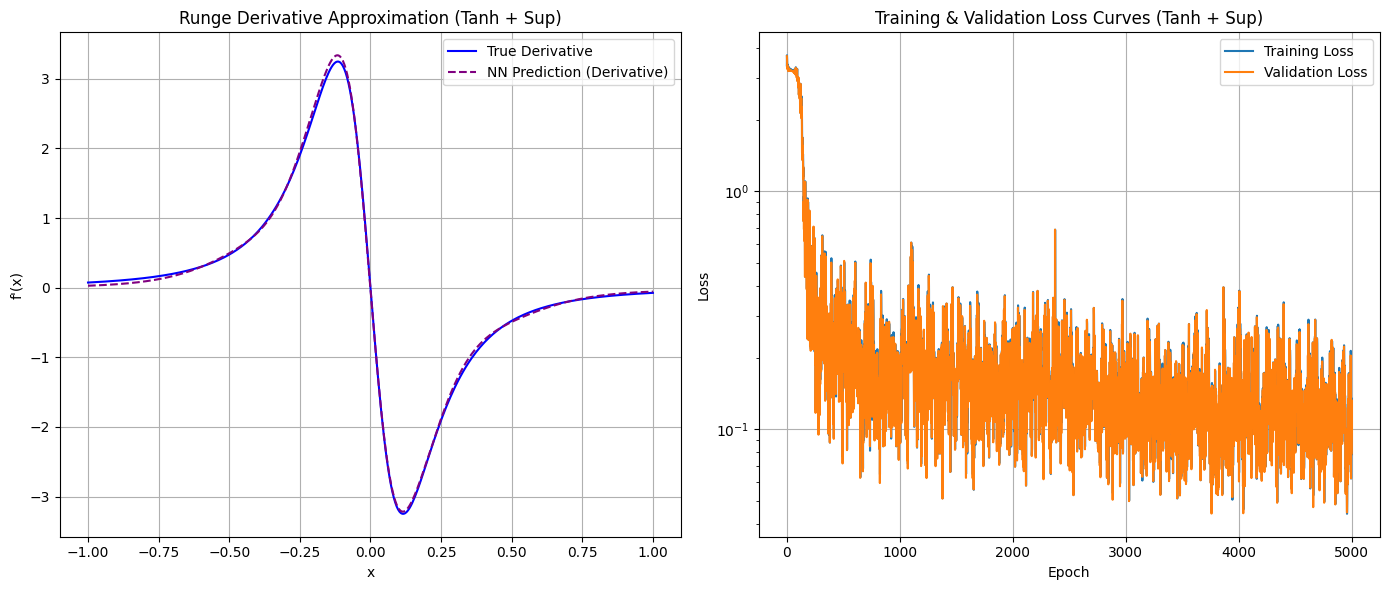

=== 3. Cosine + MSE ===
Epoch [500/5000], Train Loss: 0.001322, Val Loss: 0.001306
Epoch [1000/5000], Train Loss: 0.000520, Val Loss: 0.000515
Epoch [1500/5000], Train Loss: 0.000293, Val Loss: 0.000284
Epoch [2000/5000], Train Loss: 0.000287, Val Loss: 0.000296
Epoch [2500/5000], Train Loss: 0.000251, Val Loss: 0.001447
Epoch [3000/5000], Train Loss: 0.000155, Val Loss: 0.000167
Epoch [3500/5000], Train Loss: 0.000448, Val Loss: 0.000227
Epoch [4000/5000], Train Loss: 0.000036, Val Loss: 0.000035
Epoch [4500/5000], Train Loss: 0.000042, Val Loss: 0.000039
Epoch [5000/5000], Train Loss: 0.000072, Val Loss: 0.000086

Final MSE: 0.000086
Final Max Absolute Error (Sup-norm): 0.036319



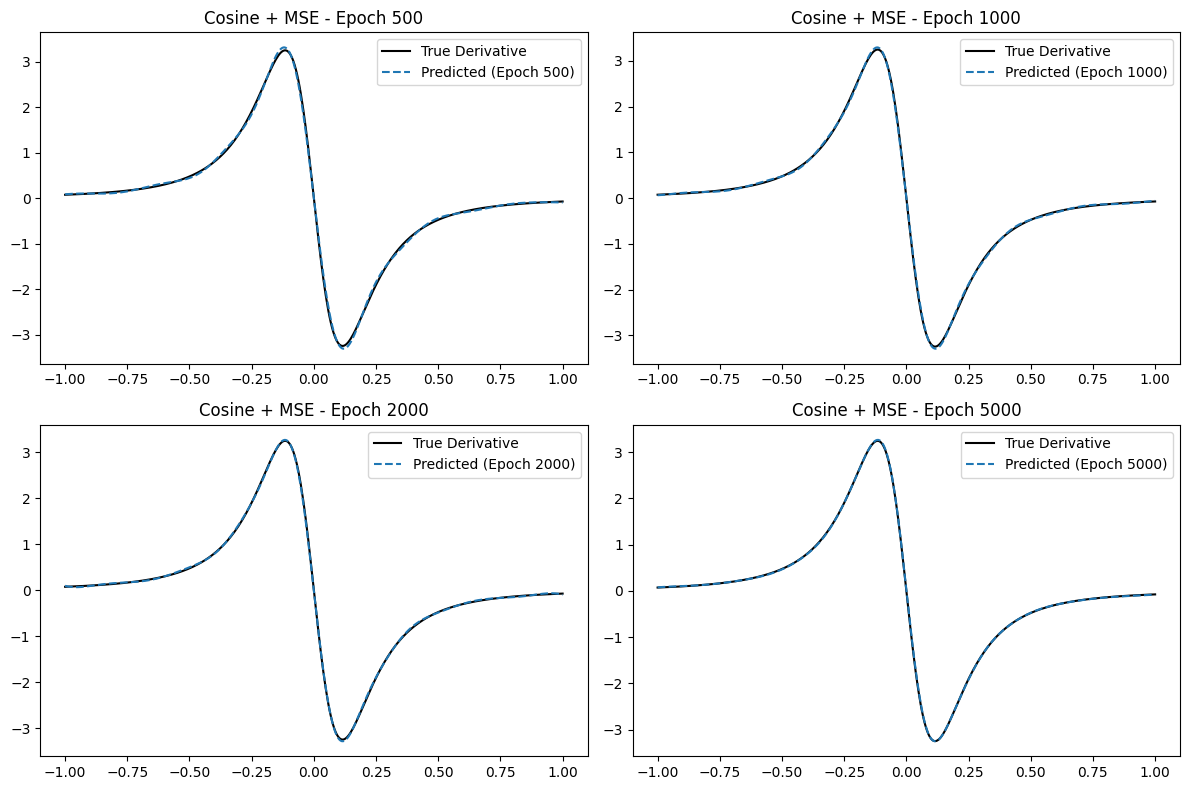

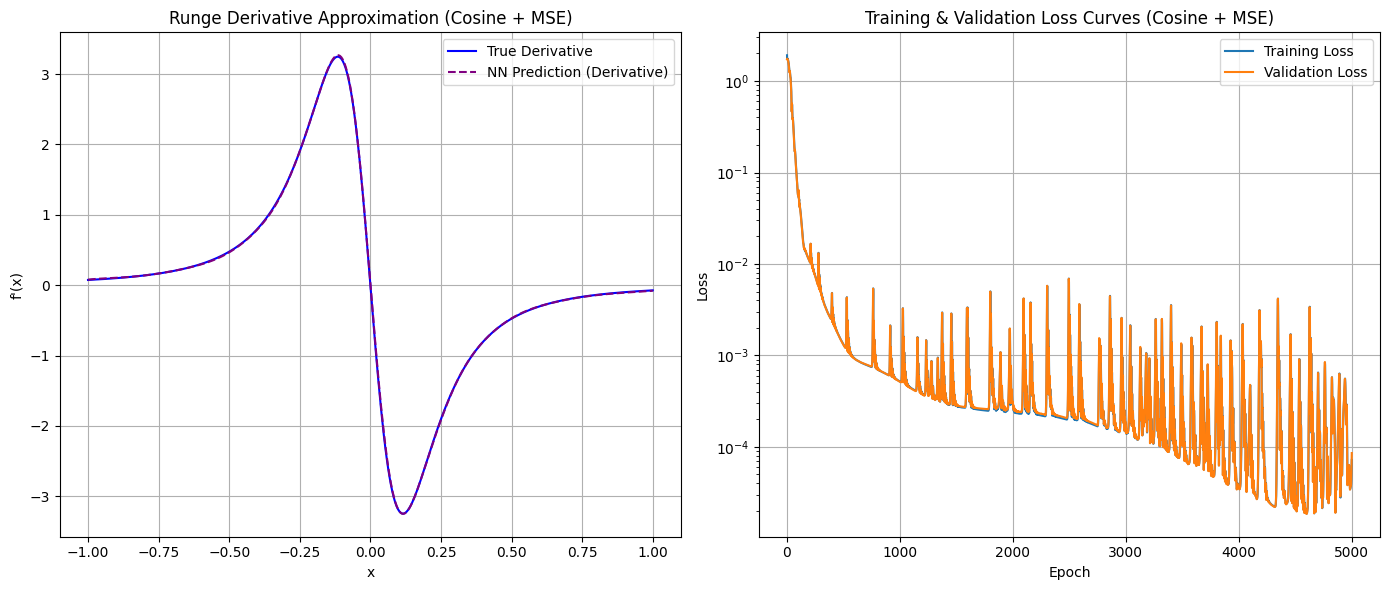

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy

# --- Runge function derivative ---
def runge_function(x):
    return 1.0 / (1 + 25 * x**2)

def runge_derivative(x):
    return -50 * x / (1 + 25 * x**2)**2

# --- Custom sup norm loss ---
def sup_norm_loss(pred, target):
    return torch.max(torch.abs(pred - target))

# --- Neural Net ---
class Net(nn.Module):
    def __init__(self, activation=torch.tanh):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# --- Training function ---
def train_and_plot(title, activation, loss_type="MSE", lr=0.01, epochs=5000):
    # Training data
    x_train = np.linspace(-1, 1, 100).reshape(-1, 1)
    dydx_train = runge_derivative(x_train)

    x_val = np.linspace(-1, 1, 50).reshape(-1, 1)
    dydx_val = runge_derivative(x_val)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    dydx_train = torch.tensor(dydx_train, dtype=torch.float32)

    x_val = torch.tensor(x_val, dtype=torch.float32)
    dydx_val = torch.tensor(dydx_val, dtype=torch.float32)

    # Model, optimizer, loss
    model = Net(activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() if loss_type == "MSE" else sup_norm_loss

    # Loss tracking
    train_losses = []
    val_losses = []

    # Checkpoints for plotting
    models_to_plot = {}

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Require grad on input
        x_batch = x_train.clone().detach().requires_grad_(True)
        y_pred = model(x_batch)

        # Predicted derivative
        dydx_pred = torch.autograd.grad(
            outputs=y_pred, inputs=x_batch,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True
        )[0]

        loss = criterion(dydx_pred, dydx_train)
        loss.backward()
        optimizer.step()

        # Validation loss
        model.eval()
        x_val_batch = x_val.clone().detach().requires_grad_(True)
        y_val_pred = model(x_val_batch)
        dydx_val_pred = torch.autograd.grad(
            outputs=y_val_pred, inputs=x_val_batch,
            grad_outputs=torch.ones_like(y_val_pred),
            create_graph=False
        )[0]
        val_loss = criterion(dydx_val_pred, dydx_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 500 == 0:
            print(f"Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")
            models_to_plot[epoch] = copy.deepcopy(model)

    # --- Final evaluation ---
    x_val_final = x_val.clone().detach().requires_grad_(True)
    y_val_final = model(x_val_final)
    dydx_val_pred = torch.autograd.grad(
        outputs=y_val_final, inputs=x_val_final,
        grad_outputs=torch.ones_like(y_val_final),
        create_graph=False
    )[0].detach().numpy()

    dydx_val_true = dydx_val.detach().numpy()
    mse_final = np.mean((dydx_val_pred - dydx_val_true)**2)
    sup_final = np.max(np.abs(dydx_val_pred - dydx_val_true))

    print(f"\nFinal MSE: {mse_final:.6f}")
    print(f"Final Max Absolute Error (Sup-norm): {sup_final:.6f}\n")

    # --- Original four-panel plots ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    epochs_to_show = [500, 1000, 2000, 5000]

    x_plot = np.linspace(-1, 1, 400).reshape(-1, 1)
    dydx_true = runge_derivative(x_plot)

    for ax, ep in zip(axes.flatten(), epochs_to_show):
        x_plot_tensor = torch.tensor(x_plot, dtype=torch.float32, requires_grad=True)
        y_pred_plot = models_to_plot[ep](x_plot_tensor)
        dydx_pred_plot = torch.autograd.grad(
            outputs=y_pred_plot, inputs=x_plot_tensor,
            grad_outputs=torch.ones_like(y_pred_plot),
            create_graph=False
        )[0].detach().numpy()

        ax.plot(x_plot, dydx_true, label="True Derivative", color="black")
        ax.plot(x_plot, dydx_pred_plot, label=f"Predicted (Epoch {ep})", linestyle="--")
        ax.legend()
        ax.set_title(f"{title} - Epoch {ep}")

    plt.tight_layout()
    plt.show()

    # --- New two-panel plots (like reference image but for derivative) ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Left: True derivative vs NN prediction
    x_plot_tensor = torch.tensor(x_plot, dtype=torch.float32, requires_grad=True)
    y_pred_plot = model(x_plot_tensor)
    dydx_pred_plot = torch.autograd.grad(
        outputs=y_pred_plot, inputs=x_plot_tensor,
        grad_outputs=torch.ones_like(y_pred_plot),
        create_graph=False
    )[0].detach().numpy()

    axes[0].plot(x_plot, dydx_true, label="True Derivative", color="blue")
    axes[0].plot(x_plot, dydx_pred_plot, label="NN Prediction (Derivative)", linestyle="--", color="purple")
    axes[0].set_title(f"Runge Derivative Approximation ({title})")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("f'(x)")
    axes[0].legend()
    axes[0].grid(True)

    # Right: Training & Validation Loss
    axes[1].plot(range(1, epochs + 1), train_losses, label="Training Loss")
    axes[1].plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    axes[1].set_yscale("log")
    axes[1].set_title(f"Training & Validation Loss Curves ({title})")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return model

# --- Three methods ---
print("=== 1. Tanh + MSE ===")
model_tanh_mse = train_and_plot("Tanh + MSE", activation=torch.tanh, loss_type="MSE")

print("=== 2. Tanh + Sup norm ===")
model_tanh_sup = train_and_plot("Tanh + Sup", activation=torch.tanh, loss_type="Sup")

print("=== 3. Cosine + MSE ===")
model_cos_mse = train_and_plot("Cosine + MSE", activation=torch.cos, loss_type="MSE")


So after the 5000 iteration, we get the final testing errors as follows:

<table>
  <thead>
    <tr>
      <th>Function</th>
      <th>Method</th>
      <th>tanh + MSE</th>
      <th>tanh + sup</th>
      <th>cos + MSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="2">f(x)</td>
      <td>Test MSE</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000006</td>
    </tr>
    <tr>
      <td>Test Max Absolute Error</td>
      <td>0.000489</td>
      <td>0.000564</td>
      <td>0.005360</td>
    </tr>
    <tr>
      <td rowspan="2">f'(x)</td>
      <td>Test MSE</td>
      <td>0.000054</td>
      <td>0.001418</td>
      <td>0.000086</td>
    </tr>
    <tr>
      <td>Test Max Absolute Error</td>
      <td>0.019007</td>
      <td>0.097872</td>
      <td>0.036319</td>
    </tr>
  </tbody>
</table>

We can see that the $\tanh$ + **MSE** method has the best performance; $\tanh$ + **sup-norm** method has the worst performance.